# El problema del desvanecimiento y explosión del gradiente

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z es una función con dominio en \[-5, 5\] dividido en 200 puntos:

In [60]:
z = np.linspace(-5, 5, 200)

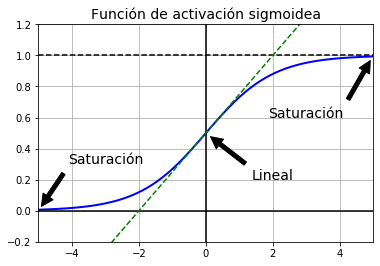

In [61]:
plt.plot(z, logit(z), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
props =  dict(facecolor='black', shrink=0.1)
plt.annotate('Saturación', xytext=(3, 0.6), xy=(5, 1), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturación', xytext=(-3, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Lineal', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha='center')
plt.grid(True)
plt.title('Función de activación sigmoidea', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

## Inicialización Xavier y He

Son dos interesantes métodos para evitar que el gradiente se sature.

**paper:** [Understanding the Difficulty of Training Deep Feedforward
Neural Networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [7]:
import tensorflow as tf
from tensorflow import keras

Existen varios métodos de inicialización, en Keras usa por defecto el Glorot.

In [82]:
[initializer for initializer in dir(keras.initializers) if not initializer.startswith('_')]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [83]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

Si queremos inicializar el método He con una distribución normal, pero basado en _fan(avg)_ en vez de _fan(in)_ usamos el inicializador **VarianceScaling**:

In [84]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)

## Funciones de activación no saturadas

El principal problema de la saturación del gradiente descendiente fue que la mayoria usaba la función sigmoidea como única elección ya que su comportamiento parece ser la dominante en la redes neuronales biológicas, pero en realidad existen otras como la ReLU que tienen una mejor eficiencia en las RNAs.

### Leaky ReLU

In [14]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

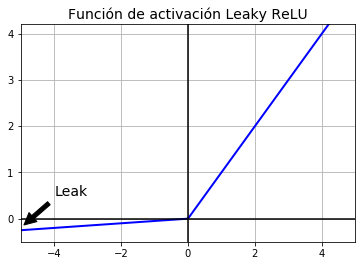

In [18]:
plt.plot(z, leaky_relu(z, 0.05), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2),arrowprops=props, fontsize=14, ha='center')
plt.title('Función de activación Leaky ReLU', fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [103]:
[func_activation for func_activation in dir(keras.activations) if not func_activation.startswith('_')]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [107]:
[func_activation for func_activation in dir(keras.layers) if 'relu' in func_activation.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

#### Conjunto de datos

In [39]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train  = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train  = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 1s 0us/step


In [153]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation='softmax'),
])

In [156]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=['accuracy'])

In [157]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 109us/sample - loss: 1.2810 - accuracy: 0.6205 - val_loss: 0.8869 - val_accuracy: 0.7160
Epoch 2/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.7952 - accuracy: 0.7369 - val_loss: 0.7132 - val_accuracy: 0.7626
Epoch 3/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.6817 - accuracy: 0.7726 - val_loss: 0.6385 - val_accuracy: 0.7894
Epoch 4/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.6219 - accuracy: 0.7942 - val_loss: 0.5931 - val_accuracy: 0.8016
Epoch 5/10
55000/55000 [==============================] - 6s 102us/sample - loss: 0.5830 - accuracy: 0.8074 - val_loss: 0.5607 - val_accuracy: 0.8170
Epoch 6/10
55000/55000 [==============================] - 6s 100us/sample - loss: 0.5552 - accuracy: 0.8172 - val_loss: 0.5355 - val_accuracy: 0.8238
Epoch 7/10
55000/55000 [===========================

### PReLU

In [161]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [162]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(lr=1e-3),
             metrics=['accuracy'])

In [163]:
model.fit(X_train, y_train,
          epochs=10,
          validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 125us/sample - loss: 1.3452 - accuracy: 0.6203 - val_loss: 0.9241 - val_accuracy: 0.7170
Epoch 2/10
55000/55000 [==============================] - 6s 117us/sample - loss: 0.8196 - accuracy: 0.7364 - val_loss: 0.7314 - val_accuracy: 0.7602
Epoch 3/10
55000/55000 [==============================] - 6s 118us/sample - loss: 0.6970 - accuracy: 0.7702 - val_loss: 0.6517 - val_accuracy: 0.7878
Epoch 4/10
55000/55000 [==============================] - 6s 117us/sample - loss: 0.6333 - accuracy: 0.7914 - val_loss: 0.6032 - val_accuracy: 0.8052
Epoch 5/10
55000/55000 [==============================] - 6s 116us/sample - loss: 0.5917 - accuracy: 0.8049 - val_loss: 0.5689 - val_accuracy: 0.8164
Epoch 6/10
55000/55000 [==============================] - 6s 116us/sample - loss: 0.5619 - accuracy: 0.8143 - val_loss: 0.5417 - val_accuracy: 0.8226
Epoch 7/10
55000/55000 [===========================

### ELU

In [25]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

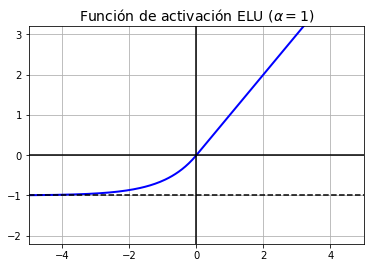

In [34]:
plt.plot(z, elu(z), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r'Función de activación ELU ($\alpha=1$)', fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

Definimos la función de activación ELU en tensorflow simplemente especificando el parámetro _activation_ en cada capa:

In [27]:
keras.layers.Dense(10, activation='elu')

### SELU

Está función de activación se aplica a redes neuronales compuestas únicamente por una pila de capas densas y la _inicialización LeCun_ se autonormalizará: La salida de cada capa tenderá a preservar la misma media y varianza durante el entrenamiento, con lo cual se resuelve el problema del desvanecimiento/explosión del gradiente.

Ventajas:
- Esta función de activación tiene  un desempeño muy superior a las funciones de activación no saturadas anteriores.
- Trabaja muy bien con RNC sequenciales

Desventajas:
- La propiedad de auto normalización puede romperse fácilmente: no se puede usar la regularización _l<sub>1</sub>_ o *l<sub>2</sub>*, dropout, max-norm, saltar conexiones u otra topología no secuencial.
- Si se rompe la auto normalización, SELU no necesariamente tendrá un mejor desempeño con respecto a las otras funciones de activación.

In [4]:
from scipy.special import erfc

In [8]:
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [11]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

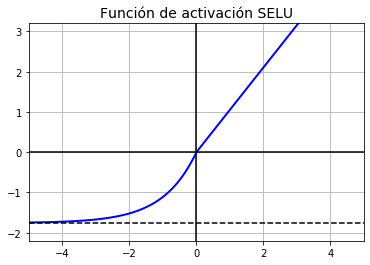

In [30]:
plt.plot(z, selu(z), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2 , 3.2], 'k-')
plt.grid(True)
plt.title('Función de activación SELU', fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

Por defecto, los hiperparámetros de SELU (scale y alpha) son ajustados de tal manera que la media de las salidas de cada neurona es cercana a 0, y la deviación estándar cercana a 1 (asumiendo que las entradas también están normalizadas con media 0 y desviación estándar 1). Usando la función de activación SELU, incluso con 1000 capas, preserva aproximadamente una media de 0 y una desviación estándar de 1 a lo largo de todas las capas, evitando el desvanecimiento/explosión del gradiente.

In [54]:
def test(func_activation, initializer):
    np.random.seed(42)
    tf.random.set_seed(42)
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    model.add(keras.layers.Dense(300, activation=func_activation, kernel_initializer=initializer))
    
    for layer in range(99):
        model.add(keras.layers.Dense(100, activation=func_activation, kernel_initializer=initializer))

    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=1e-3),
                  metrics=['accuracy'])
    
    return model.fit(X_train_scaled, y_train, epochs=5,
              validation_data=(X_valid_scaled, y_valid))
    

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))

model.add(keras.layers.Dense(10, activation='softmax'))

In [33]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(lr=1e-3),
             metrics=['accuracy'])

#### Entrenamiento

Antes de entrenar debemos normalizar las entradas:

In [50]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [56]:
history = test('selu', 'lecun_normal')

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 40s 724us/sample - loss: 1.0961 - accuracy: 0.5928 - val_loss: 0.9184 - val_accuracy: 0.6616
Epoch 2/5
55000/55000 [==============================] - 37s 665us/sample - loss: 0.7975 - accuracy: 0.7119 - val_loss: 0.6908 - val_accuracy: 0.7534
Epoch 3/5
55000/55000 [==============================] - 37s 672us/sample - loss: 0.6791 - accuracy: 0.7523 - val_loss: 0.6029 - val_accuracy: 0.7816
Epoch 4/5
55000/55000 [==============================] - 37s 672us/sample - loss: 0.5899 - accuracy: 0.7878 - val_loss: 0.5317 - val_accuracy: 0.8086
Epoch 5/5
55000/55000 [==============================] - 37s 669us/sample - loss: 0.5757 - accuracy: 0.7915 - val_loss: 0.5622 - val_accuracy: 0.8000


In [55]:
history = test('relu', 'he_normal')

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 36s 660us/sample - loss: 1.7764 - accuracy: 0.2742 - val_loss: 1.2831 - val_accuracy: 0.4094
Epoch 2/5
55000/55000 [==============================] - 34s 614us/sample - loss: 1.1872 - accuracy: 0.4867 - val_loss: 1.0905 - val_accuracy: 0.5412
Epoch 3/5
55000/55000 [==============================] - 34s 616us/sample - loss: 0.9839 - accuracy: 0.5956 - val_loss: 1.1566 - val_accuracy: 0.4860
Epoch 4/5
55000/55000 [==============================] - 33s 609us/sample - loss: 0.8547 - accuracy: 0.6582 - val_loss: 0.8286 - val_accuracy: 0.6730
Epoch 5/5
55000/55000 [==============================] - 33s 609us/sample - loss: 0.7793 - accuracy: 0.6951 - val_loss: 0.7933 - val_accuracy: 0.7068
